In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from blender_dataloader import *
from constants import *
from imports import *
from train_utils import get_torque

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
get_obs_per_sec()

196.40277

In [3]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([19.167421, 16.768425, 20.073135, 14.860769, 15.344524, 14.391554,
       13.305691, 15.561939, 16.323679, 15.442533, 15.467044, 19.696064],
      dtype=float32)

In [4]:
set_should_stop(True)

In [6]:
dataloader = BlenderDataloader("trn", 6)

In [7]:
dataloader.get_obs_per_second()

196.40277

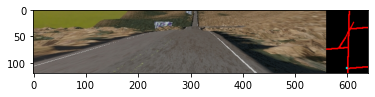

In [8]:
ix = 4
plt.imshow(dataloader.img_chunk[ix][0])

(array([  5.,   6.,  23., 121., 199., 531., 742., 613., 944., 296.]),
 array([24.619883, 30.47639 , 36.3329  , 42.189407, 48.045918, 53.902424,
        59.758934, 65.61544 , 71.47195 , 77.32846 , 83.18497 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

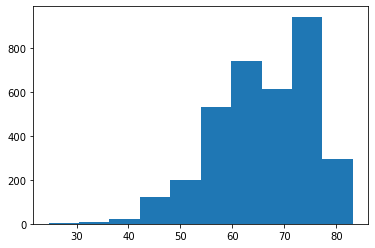

In [9]:
plt.hist(dataloader.aux_chunk[:,:,2].flatten())

(array([  55.,  175.,  260.,  547.,  597., 1125.,  347.,  274.,   67.,
          33.]),
 array([-0.11976784, -0.09586736, -0.07196689, -0.04806641, -0.02416593,
        -0.00026546,  0.02363502,  0.04753549,  0.07143597,  0.09533644,
         0.11923692], dtype=float32),
 <BarContainer object of 10 artists>)

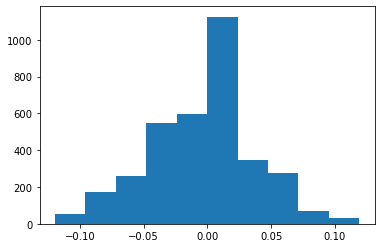

In [10]:
plt.hist(dataloader.targets_chunk[:,:,14].flatten())

In [11]:
%%time
batch, is_first_in_seq = dataloader.get_batch()

(img, 
                                    aux, 
                                    wp_angles,
                                     wp_headings,
                                     wp_curvatures,
                                     to_pred_mask,
                                    current_tire_angles_rad, # Extras
                                    current_speeds_mps, 
                                    pitch, 
                                    yaw) = batch

is_first_in_seq

CPU times: user 1.08 ms, sys: 178 µs, total: 1.26 ms
Wall time: 1.13 ms


True

In [12]:
wp_angles.shape, wp_headings.shape, wp_curvatures.shape

(torch.Size([6, 9, 30]), torch.Size([6, 9, 30]), torch.Size([6, 9, 30]))

(array([ 12.,  17.,  32., 190., 131.,  85., 190., 495., 331., 137.]),
 array([-3.97   , -3.42   , -2.867  , -2.316  , -1.766  , -1.214  ,
        -0.6626 , -0.11115,  0.4402 ,  0.9917 ,  1.543  ], dtype=float16),
 <BarContainer object of 10 artists>)

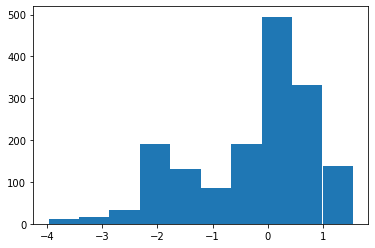

In [13]:
plt.hist((wp_angles*to_pred_mask).flatten().detach().cpu().numpy())

In [14]:
3.3*.54

1.782

(array([ 18.,   9.,  26., 164., 199.,  52., 189., 495., 314., 154.]),
 array([-4.457 , -3.857 , -3.26  , -2.66  , -2.062 , -1.463 , -0.8643,
        -0.2651,  0.3335,  0.9326,  1.531 ], dtype=float16),
 <BarContainer object of 10 artists>)

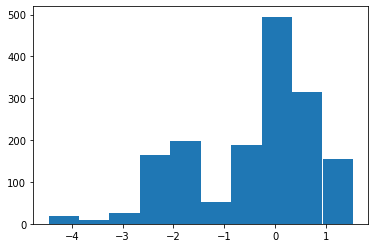

In [15]:
plt.hist((wp_headings*to_pred_mask).flatten().detach().cpu().numpy())

(array([107., 159.,  96.,  33.,  75., 188.,  26., 542., 231., 163.]),
 array([-0.659   , -0.565   , -0.471   , -0.377   , -0.283   , -0.1888  ,
        -0.0948  , -0.000708,  0.0934  ,  0.1874  ,  0.2815  ],
       dtype=float16),
 <BarContainer object of 10 artists>)

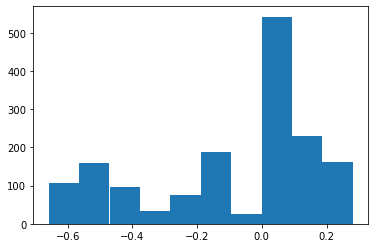

In [16]:
plt.hist((wp_curvatures*to_pred_mask).flatten().detach().cpu().numpy())

In [17]:
to_pred_mask.sum() / to_pred_mask.numel()

tensor(0.8555, device='cuda:0', dtype=torch.float16)

(array([15., 12., 18.,  0.,  0.,  0.,  0.,  2.,  4.,  3.]),
 array([-4178.9443 , -2366.4531 ,  -553.96173,  1258.5295 ,  3071.021  ,
         4883.512  ,  6696.0034 ,  8508.495  , 10320.986  , 12133.478  ,
        13945.969  ], dtype=float32),
 <BarContainer object of 10 artists>)

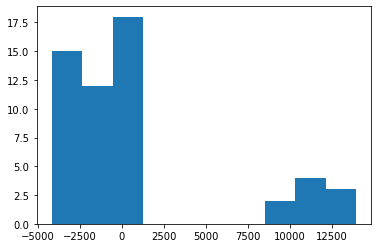

In [18]:
t = get_torque(wp_angles, aux)
plt.hist(t.cpu().numpy().flatten())

In [19]:
abs(t).max()

tensor(13945.9688, device='cuda:0')

(array([24., 13.,  5.,  0.,  2.,  1.,  2.,  0.,  0.,  1.]),
 array([   0.     ,  126.90752,  253.81503,  380.72256,  507.63007,
         634.5376 ,  761.4451 ,  888.35266, 1015.26013, 1142.1677 ,
        1269.0752 ], dtype=float32),
 <BarContainer object of 10 artists>)

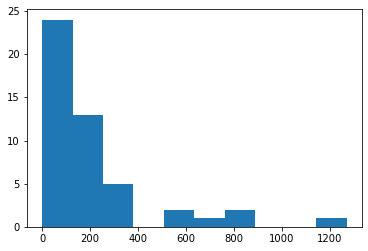

In [20]:
td = abs(t[:,1:,:] - t[:,:-1,:])
plt.hist(td.cpu().numpy().flatten())

In [21]:
abs(td).max()

tensor(1269.0752, device='cuda:0')

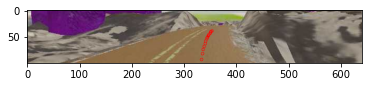

In [67]:

traj = dataloader.targets_chunk[ix][0]
img = dataloader.img_chunk[ix][0]

plt.imshow(draw_wps(img, traj))

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)